In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score, precision_score, recall_score,confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.utils import load_img,img_to_array
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Input,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# We need to set seed for any randomizing that will happen during process
SEED = 44
AUTOTUNE = tf.data.experimental.AUTOTUNE
shape = 256
# Train, Test, Validation split sizes
split_size_train = 0.8
split_size_test = 0.1
split_size_val = 0.1

In [3]:
def load_from_directory(filename,batch_size):
    data = tf.keras.utils.image_dataset_from_directory(filename,
                                                       batch_size=batch_size,
                                                       image_size=(shape,shape),
                                                       seed=SEED,labels="inferred",
                                                       label_mode="int",
                                                       shuffle=True)
    return data
# We split our dataset into train and validation sets
def split_dir_dataset(data):
    # scale down rgb from 255 to 0
    # data = data.map(lambda x,y: (x/255,y))
    
    # percent size of train and val sets
    train_size = int(len(data)* split_size_train)
    test_size = int(len(data) * split_size_test)
    val_size = int(len(data)* split_size_val)
    
    
    # take that size images from dataset
    train = data.take(train_size)
    val = data.skip(train_size).take(val_size)
    test = data.skip(train_size+val_size).take(test_size)
    
    
    print(f'training shape: {train.as_numpy_iterator().next()[0].shape}')
    return train,test,val

In [4]:
def get_dataset(batch_size):
    # path to our dataset
    dataset_path = '../image_training_data/'
    
    data = load_from_directory(dataset_path,batch_size)
    
    train,test, val = split_dir_dataset(data)
    # train = train.cache()
    train = train.prefetch(buffer_size=AUTOTUNE)
    val = val.prefetch(buffer_size=AUTOTUNE)
    test = test.prefetch(buffer_size=AUTOTUNE)

    return train,val,test

In [5]:
train,val,test = get_dataset(64)

Found 1093271 files belonging to 2 classes.
training shape: (64, 256, 256, 3)


In [6]:
output_len = 2  #len(data.class_names)
print(output_len)

2


In [5]:
def show_samples_dataset(data):
    class_names = data.class_names
    plt.figure(figsize=(10, 10))
    for images, labels in data.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
          
def show_results(hist,mode='acc'):
    if mode == 'acc' or mode == 'accuracy':
        mode = 'accuracy'
        val_mode = 'val_accuracy'
    elif mode == 'loss':
        mode = "loss"
        val_mode = "val_loss"
    
    fig = plt.figure()
    plt.plot(hist.history[mode], color='teal', label=mode)
    plt.plot(hist.history[val_mode], color='orange', label=val_mode)
    fig.suptitle(mode, fontsize=20)
    plt.legend(loc="upper left")
    plt.show()
    
def prediction_dir_dataset(model,test,data):
    y_true = []
    y_pred = []
    length = int(len(data) * .10)
    index = 0
    for batch in test: 
        X, y = batch
        yhat = model.predict(X)
        yhat = np.argmax(yhat,axis=1)
        y_true.append(y)
        y_pred.append(yhat)
        print(f"Progress: {index}/{length}", end='\r')
        index += len(X)
    y_true = np.array(y_true)
    y_true = y_true.reshape(-1)
    y_pred = np.array(y_pred)
    y_pred = y_pred.reshape(-1)
    
    return y_true, y_pred

def scores(y_true,y_pred,show_confusion_matrix=True):
    precision_micro = precision_score(y_true, y_pred, average='micro')
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f2_micro = fbeta_score(y_true, y_pred, beta=2, average='micro')
    f2_weighted = fbeta_score(y_true, y_pred, beta=2, average='weighted')
    
    if show_confusion_matrix == True:
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
    print(f"precision weighted: {'{:.3f}'.format(precision_weighted)}\nprecision micro: {precision_micro} ")
    print(f'recall weighted: {recall_weighted}\nrecall micro: {recall_micro} ')
    print(f'f1 weighted: {"{:.3f}".format(f1_weighted)}\nf1 micro: {f1_micro} ')
    print(f'f2 weighted: {"{:.3f}".format(f2_weighted)}\nf2 micro: {f2_micro} ')
    


In [8]:
def data_augment(X):
    X = RandomZoom(0.2)(X)
    X = RandomFlip(mode="horizontal_and_vertical", seed=SEED)(X)
    X = RandomRotation(factor=0.8)(X)
    X = RandomContrast(0.6, seed=SEED)(X)
    return X

In [9]:
input_shape = (shape,shape,3)
base_model = EfficientNetV2B0(input_shape=input_shape, weights='imagenet',include_top=False, include_preprocessing=True)


In [10]:
# initialize input shape layer for data augmentation block
x_input = Input(input_shape)
x = data_augment(x_input)

# connect data augmentation block to base model
x = base_model(x)

# Global spatial avg pooling layer
x = GlobalAveragePooling2D()(x)

# Fully connected layer
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)


# We have 2 classes either it is suitable for children or not
predictions = Dense(output_len,activation='softmax')(x)

# this is the model we will train
model = Model(inputs=x_input, outputs=predictions)


In [11]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional MobileNetV3 layers
for layer in base_model.layers:
    layer.trainable = False

# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",   # Watch validation loss
    factor=0.5,           # Reduce LR by 50% when triggered
    patience=3,           # Wait 3 epochs before reducing LR
    min_lr=1e-6,          # Do not go below this LR
    verbose=1             # Print when LR is reduced
)

initial_lr = 1e-3
lr_schedule = ExponentialDecay(
    initial_lr, decay_steps=5000, decay_rate=0.8, staircase=True
)

optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
             loss=tf.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])



In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 random_contrast (RandomCont  (None, 256, 256, 3)      0         
 rast)                                                           
                                                                 
 efficientnetv2-b0 (Function  (None, 8, 8, 1280)       591931

In [13]:

# choose model name
model_name = f"EfficientNetV2B0_128_64_32_frozen.h5"



In [14]:
# train the model on the new data for a few epochs
epochs = 1

hist = model.fit(train,
                 epochs = epochs,
                 validation_data=val,
                 callbacks=[reduce_lr]
                 # callbacks = [checkpoint,early_stopping]
                 # ,validation_freq=VAL_FREQ
                )

 3015/13666 [=====>........................] - ETA: 31:46 - loss: 0.2232 - accuracy: 0.9153


KeyboardInterrupt



# Unforzen model training


In [15]:
model_name ="EfficientNetV2B0_128_64_32_frozen.h5" 
model.save(model_name)

In [16]:
model = tf.keras.models.load_model(model_name)

train,val,test = get_dataset(12)
# Define callbacks
model_name = f"EfficientNetV2B0_128_64_32.h5"

checkpoint = ModelCheckpoint(model_name, monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='min')
for layer in model.layers:
   layer.trainable = True

Found 1093271 files belonging to 2 classes.
training shape: (12, 256, 256, 3)


In [21]:
# we need to recompile the model for these modifications to take effect
# we use adam with a low learning rate
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"]
             )

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",   # Watch validation loss
    factor=0.5,           # Reduce LR by 50% when triggered
    patience=2,           # Wait 3 epochs before reducing LR
    min_lr=1e-6,          # Do not go below this LR
    verbose=1             # Print when LR is reduced
)

In [22]:
epochs = 5
hist_unfreezed = model.fit(train,
                 epochs = epochs,
                 validation_data=val,
                 callbacks = [checkpoint,early_stopping,reduce_lr]
                 # ,validation_freq=VAL_FREQ
                )

Epoch 1/5
72884/72884 [==============================] - 9346s 128ms/step - loss: 0.1497 - accuracy: 0.9478 - val_loss: 0.0903 - val_accuracy: 0.9674 - lr: 1.0000e-05
Epoch 2/5
48905/72884 [===================>..........] - ETA: 47:02 - loss: 0.1058 - accuracy: 0.9642

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x00000137105C25E0>
Traceback (most recent call last):
  File "C:\Users\Saba\.conda\envs\AI\lib\weakref.py", line 371, in remove
KeyboardInterrupt: 

KeyboardInterrupt



In [23]:
model.save("EfficientNetV2B0_128_64_32_2nd_epoch.h5") 


Found 1093271 files belonging to 2 classes.
training shape: (256, 256, 256, 3)


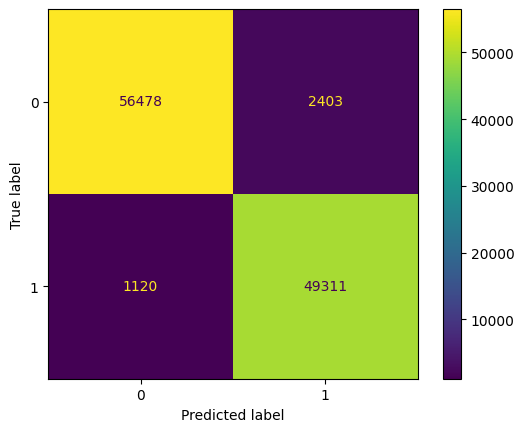

precision weighted: 0.968
precision micro: 0.967771150468384 
recall weighted: 0.967771150468384
recall micro: 0.967771150468384 
f1 weighted: 0.968
f1 micro: 0.967771150468384 
f2 weighted: 0.968
f2 micro: 0.967771150468384 


In [6]:
# path to our dataset
dataset_path = '../image_training_data/'

data = load_from_directory(dataset_path,256)

train,test, val = split_dir_dataset(data)
# train = train.cache()
train = train.prefetch(buffer_size=AUTOTUNE)
val = val.prefetch(buffer_size=AUTOTUNE)
test = test.prefetch(buffer_size=AUTOTUNE)


model = tf.keras.models.load_model('./models/image_classification/256/EfficientNetV2B0_128_64_32.h5')
y_true, y_pred = prediction_dir_dataset(model,test,data)

scores(y_true,y_pred)

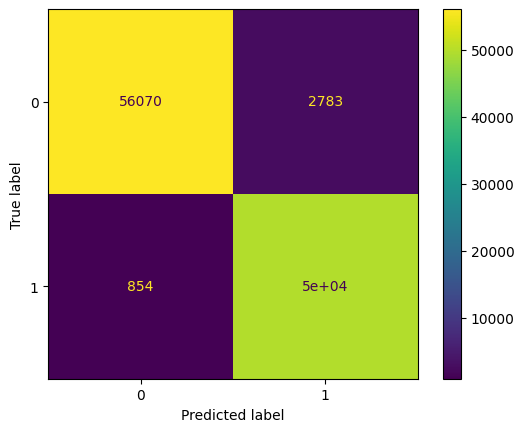

precision weighted: 0.967
precision micro: 0.9667282640515222 
recall weighted: 0.9667282640515222
recall micro: 0.9667282640515222 
f1 weighted: 0.967
f1 micro: 0.9667282640515222 
f2 weighted: 0.967
f2 micro: 0.9667282640515222 


In [7]:
model = tf.keras.models.load_model('./models/image_classification/256/EfficientNetV2B0_256_128_32.h5')
y_true, y_pred = prediction_dir_dataset(model,test,data)

scores(y_true,y_pred)